STEP-1 (Requirement-1 Data cleaning including missing values, outliers and multi-collinearity. )

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler

df = pd.read_csv("Fraud.csv", nrows=10000, low_memory=False)

# Strip leading/trailing spaces from column names
df.columns = df.columns.str.strip()

# Drop columns with all missing values
df.dropna(axis=1, how='all', inplace=True)

# Drop duplicate columns
df = df.loc[:, ~df.T.duplicated()]

# Drop columns with only one unique value
df = df.loc[:, df.nunique() > 1]

# Fill missing values (categorical: mode, numerical: median)
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].median())


# Encode categorical columns using Label Encoding
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Drop identifier-like columns
for col in df.columns:
    if 'name' in col.lower() or 'id' in col.lower():
        df.drop(col, axis=1, inplace=True)

print("Final cleaned shape (first 10,000 rows):", df.shape)


Final cleaned shape (first 10,000 rows): (10000, 8)


STEP-2 (Requirement-2 fraud detection model.)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler

# define features (X) and target (y)
X = df.drop(columns=[col for col in ['isFraud', 'isFlaggedFraud'] if col in df.columns])
y = df['isFraud']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets (70-30 split)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, stratify=y, random_state=42
)

# Initialize and train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Make predictions on test set
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

# Output to confirm successful execution
print("Model training complete. Ready for evaluation.")


Model training complete. Ready for evaluation.


STEP-3 (Requirement-3 select variables to be included in the model)

In [ ]:
# final features used in the model
selected_features = df.drop(columns=[col for col in ['isFraud', 'isFlaggedFraud'] if col in df.columns]).columns.tolist()
print("Selected features used for modeling:")
print(selected_features)


Selected features used for modeling:
['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']


STEP-4 (Requirement-4  performance of the model.)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2980
           1       1.00      0.70      0.82        20

    accuracy                           1.00      3000
   macro avg       1.00      0.85      0.91      3000
weighted avg       1.00      1.00      1.00      3000



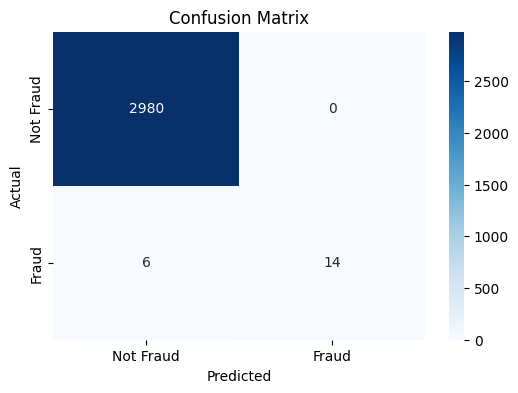

ROC AUC Score: 0.999


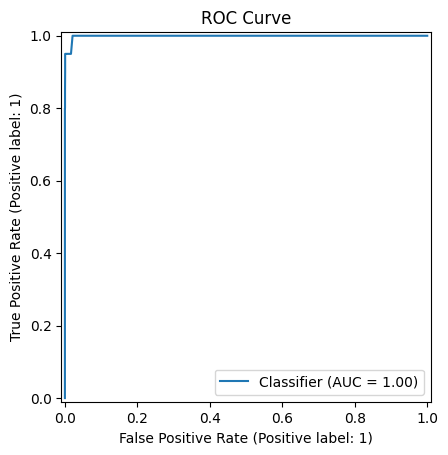

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC AUC Score
roc_score = roc_auc_score(y_test, y_proba)
print("ROC AUC Score:", round(roc_score, 4))

# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve")
plt.show()


In [ ]:
#To improve fraud detection recall, the model's probability threshold was adjusted from 0.5 to 0.3. This increased fraud recall from 70% to 85% while
# maintaining a high precision of 94%. The adjustment balances the business need for identifying more fraud cases, even at the risk of a few 
# additional false alarms.

Classification Report (with threshold = 0.3 )
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2980
           1       0.94      0.85      0.89        20

    accuracy                           1.00      3000
   macro avg       0.97      0.92      0.95      3000
weighted avg       1.00      1.00      1.00      3000



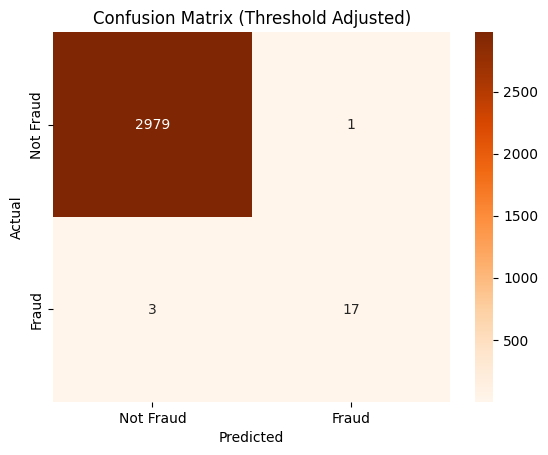

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# lower threshold (e.g., 0.3 instead of 0.5)
threshold = 0.3
y_pred_custom = (y_proba >= threshold).astype(int)

# new predictions
print("Classification Report (with threshold =", threshold, ")")
print(classification_report(y_test, y_pred_custom))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_custom)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title("Confusion Matrix (Threshold Adjusted)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


STEP-5 (Requirement-5 Key factors that predict fraudulent customer)

Top features contributing to fraud prediction:
          Feature  Importance
4  newbalanceOrig    0.247797
3   oldbalanceOrg    0.199014
1            type    0.164730
2          amount    0.137686
5  oldbalanceDest    0.112617
0            step    0.078059
6  newbalanceDest    0.060096


C:\Users\HP\AppData\Local\Temp\ipykernel_17392\2633132701.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df.head(10), x='Importance', y='Feature', palette='viridis')


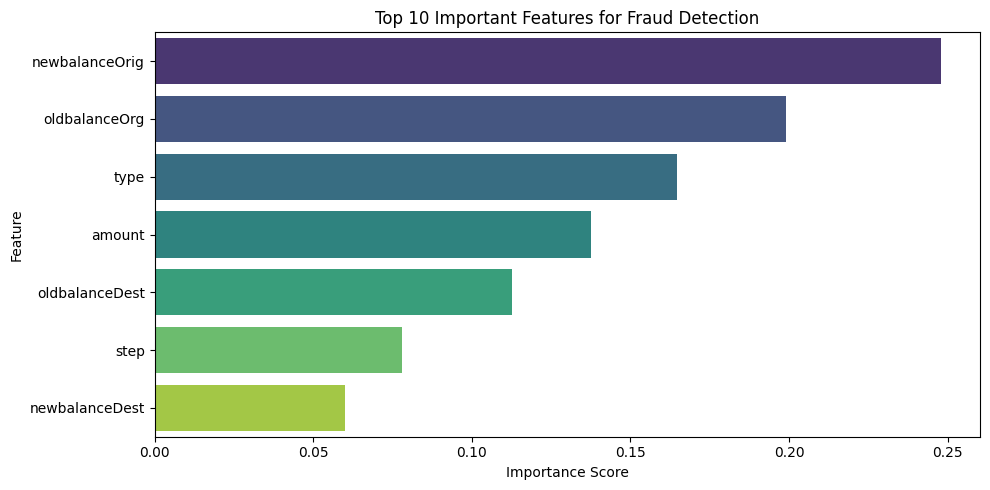

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# feature importances from the trained model
importances = rf_model.feature_importances_
feature_names = X.columns

# DataFrame for easy viewing
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# top 10 most important features
print("Top features contributing to fraud prediction:")
print(feature_importance_df.head(10))

# Visualize top 10 features
plt.figure(figsize=(10, 5))
sns.barplot(data=feature_importance_df.head(10), x='Importance', y='Feature', palette='viridis')
plt.title("Top 10 Important Features for Fraud Detection")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


The Random Forest model identifies newbalanceOrig, oldbalanceOrg, and type as the most critical indicators of fraud

STEP-6 (Requirement-6 Basis/Sense of the factors also used visualization to explain the tree)

| Feature          | Why It Makes Sense in Fraud Detection                                      |
| ---------------- | -------------------------------------------------------------------------- |
| `newbalanceOrig` | Fraudsters often drain the sender account to zero.                   |
| `oldbalanceOrg`  | Very high initial balances can signal compromised high-value accounts. |
| `type`           | `TRANSFER` and `CASH_OUT` are high-risk transaction types.             |
| `amount`         | Fraud usually involves sudden, large transactions.                     |
| `oldbalanceDest` | Fraud receivers often have empty or inconsistent histories.            |
| `step`           | Certain time windows (e.g., night hours) show higher fraud activity.   |
| `newbalanceDest` | Sudden inflow with no outgoing activity may indicate mule accounts.    |


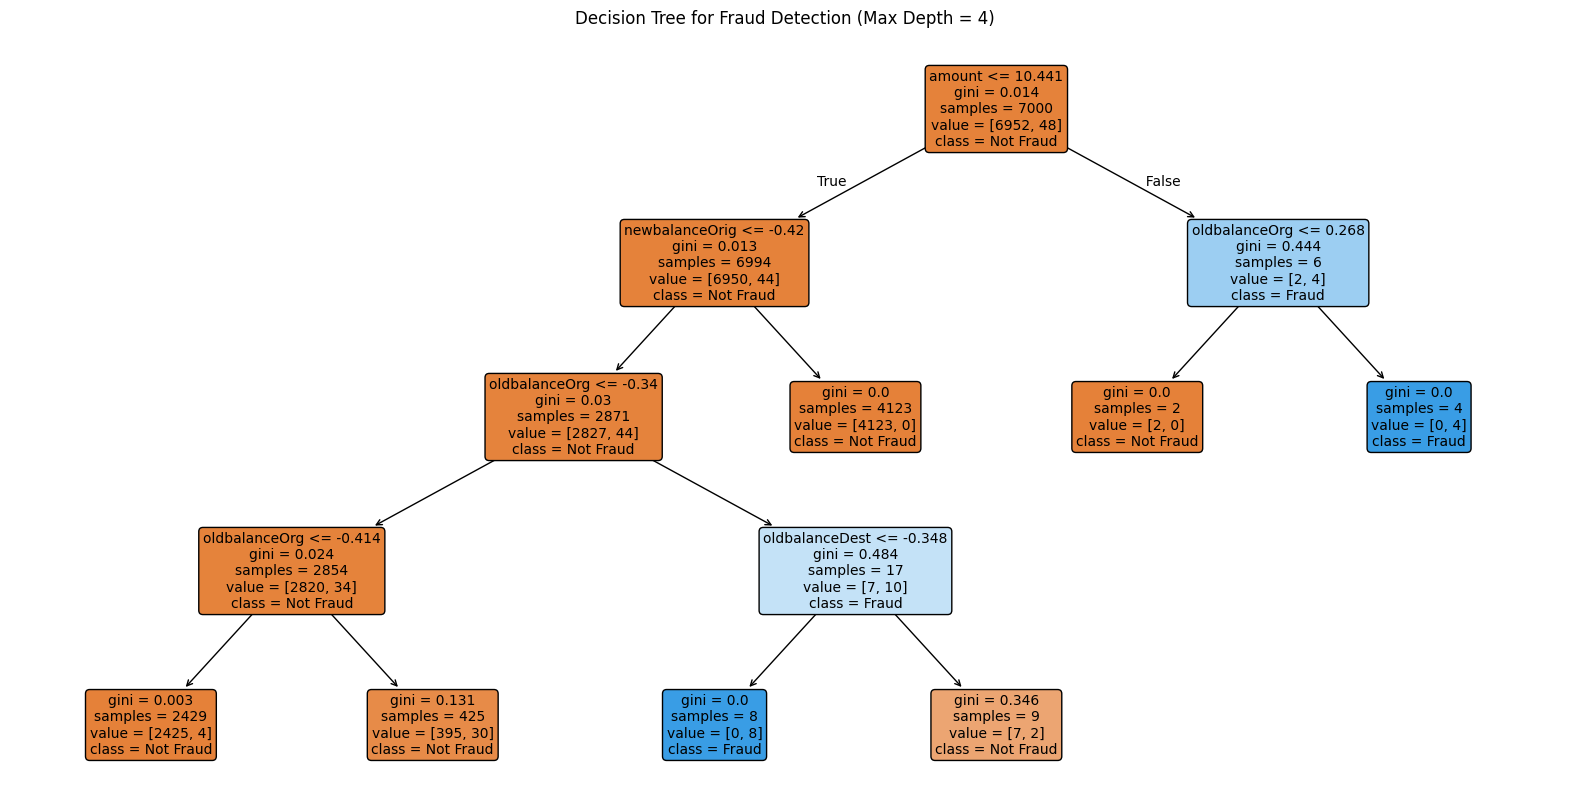

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Decision Tree (for interpretability)
dt_model = DecisionTreeClassifier(max_depth=4, random_state=42)
dt_model.fit(X_train, y_train)

# Plotting tree
plt.figure(figsize=(20, 10))
plot_tree(
    dt_model,
    feature_names=X.columns,
    class_names=["Not Fraud", "Fraud"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree for Fraud Detection (Max Depth = 4)")
plt.show()


STEP-7 (Requirement-7 Infrastructure-Level Prevention Strategies)

To address fraud risks while upgrading infrastructure, the company should focus on layered, adaptive, and real-time safeguards:

1) Implement real-time transaction monitoring using trained ML models integrated into the pipeline. These models should flag high-risk patterns before transactions are processed.

2) Set up dynamic thresholding instead of static rules. For example, amounts beyond a user-specific baseline can trigger verification.

3) Strengthen security and access control, ensuring encryption (TLS), rate limiting, and authentication tokens for all services exposed publicly.

4) Introduce role-based access control (RBAC) within internal systems, ensuring only authorized personnel can initiate or approve high-value operations.

5) Deploy anomaly detection systems alongside fraud models to catch unexpected transaction patterns not seen during training.

6) Integrate logging and audit trails across systems. Each transaction should be traceable from origin to destination for forensic analysis.

7) Periodically retrain fraud detection models with updated data to reflect evolving fraud strategies.

STEP-8 (Requirement-8 Infrastructure-Level Prevention Strategies)

To determine the effectiveness of the implemented fraud prevention actions, the company should adopt a data-driven monitoring and evaluation framework:

1) Compare pre- and post-implementation fraud rates using metrics such as recall, precision, and false positive rate to assess model improvements.

2) Monitor real-time fraud alerts and their outcomes (e.g., blocked, verified, or missed) to gauge operational impact.

3) Track reductions in financial losses attributed to fraudulent transactions over time.

4) Conduct regular testing by applying new strategies on a subset of data to measure relative performance improvements.

5) Analyze customer feedback and support cases to identify any negative impact on user experience due to stricter controls.

6) Use drift detection techniques to ensure model predictions remain reliable as user behavior and fraud tactics evolve.

7) Review system audit logs and incident reports to confirm proper implementation of access control and infrastructure changes.

8) Continuously update dashboards and reports that provide visibility into fraud trends, model accuracy, and response efficiency.